In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np
import pandas as pd


In [ ]:
# link to the GitHub CSV file
data_url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'

# read data from the URL as a pandas dataframe
covid_data = pd.read_csv(data_url)

df = pd.read_csv('https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv')

# Function to fill missing values with the average of previous and next values
def fill_missing_with_avg(series):
    for i in range(1, len(series) - 1):
        if pd.isna(series[i]):
            prev_value = series[i - 1]
            next_value = series[i + 1]
            # Check that both previous and next values are not NaN
            if pd.notna(prev_value) and pd.notna(next_value):
                series[i] = (prev_value + next_value) / 2
    # Handle missing values at the start or end by forward and backward filling
    return series.ffill().bfill()

# Apply the function to the numeric columns only
df_cleaned = df.apply(lambda col: fill_missing_with_avg(col).round() if col.dtype in ['float64', 'int64'] else col)
df_cleaned.tail()

# Specify the output file name
output_file = 'cleaned_covid19za_provincial_cumulative_timeline_confirmed.csv'

In [ ]:
# Save the cleaned DataFrame to a new CSV file
df_cleaned.to_csv(output_file, index=False)

print(f"Cleaned data saved check on FOLDER: {output_file}")

Cleaned data saved check on FOLDER: cleaned_covid19za_provincial_cumulative_timeline_confirmed.csv


In [ ]:
df = pd.read_csv('cleaned_covid19za_provincial_cumulative_timeline_confirmed.csv')

# Convert the 'YYYYMMDD' column to datetime format
df['YYYYMMDD'] = pd.to_datetime(df['YYYYMMDD'], format='%Y%m%d')

# Extract only the 'YYYYMMDD' and 'GP' (Gauteng) columns
df_extracted = df[['YYYYMMDD', 'GP']]

# Load the cleaned CSV file
df = pd.read_csv('cleaned_covid19za_provincial_cumulative_timeline_confirmed.csv')

# Convert the 'YYYYMMDD' column to datetime format
df['YYYYMMDD'] = pd.to_datetime(df['YYYYMMDD'], format='%Y%m%d')

# Define the start and end dates for filtering
start_date = '2021-04-01'
end_date = '2021-09-01'

# Filter the data for the specified date range
df_filtered = df[(df['YYYYMMDD'] >= start_date) & (df['YYYYMMDD'] <= end_date)]

# Extract only the 'YYYYMMDD' and 'GP' (Gauteng) columns
data = df_filtered[['YYYYMMDD', 'GP']].copy()

# Calculate the frequency of new cases
data.loc[:, 'Frequency'] = data['GP'].diff().fillna(0).astype(int)

# Reorder columns
data = data[['YYYYMMDD', 'Frequency', 'GP']]

# Reset index and start from 1
data.reset_index(drop=True, inplace=True)
data.index = data.index + 1

# Save the DataFrame to a CSV file
data.to_csv('filtered_gauteng_covid19_data.csv', index=False)

# Display the first few rows of the DataFrame with the frequency column
print(data.head())

    YYYYMMDD  Frequency        GP
1 2021-04-01          0  414623.0
2 2021-04-02        415  415038.0
3 2021-04-03        228  415266.0
4 2021-04-04        154  415420.0
5 2021-04-05        120  415540.0


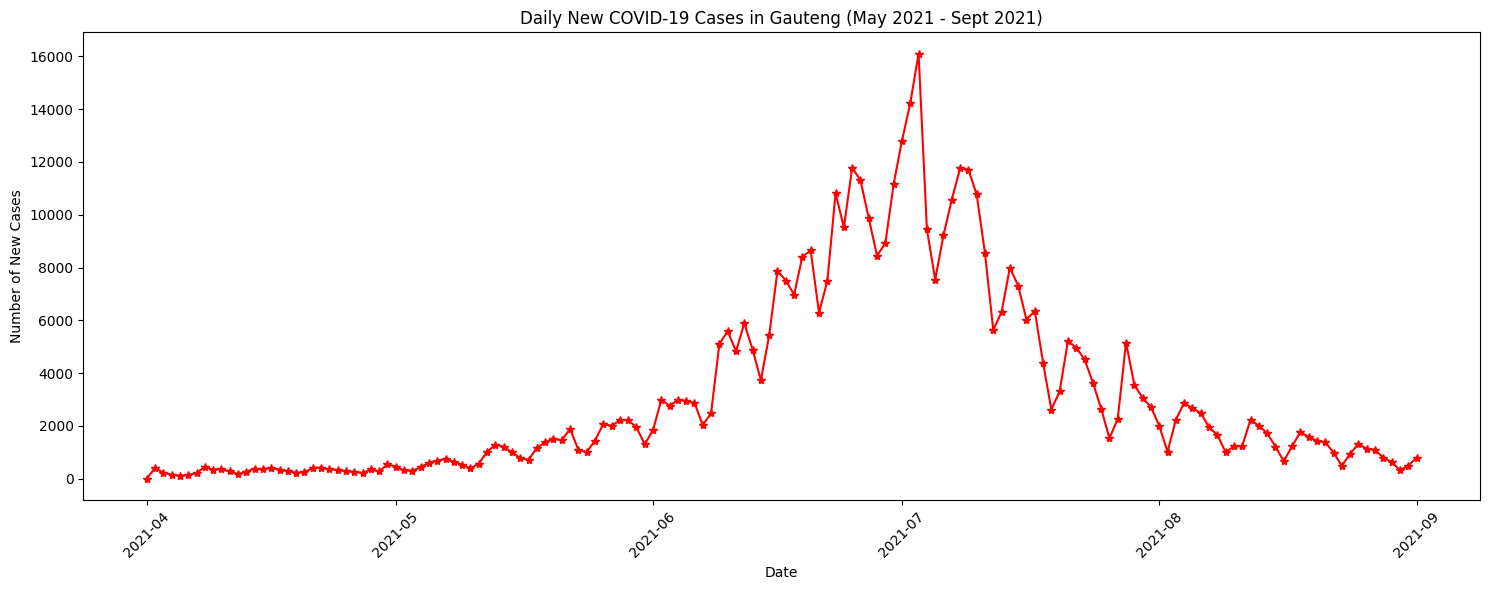

In [ ]:
# Convert the 'YYYYMMDD' column to datetime format
data['YYYYMMDD'] = pd.to_datetime(data['YYYYMMDD'], format='%Y-%m-%d')

plt.figure(figsize=(15, 6))
plt.plot(data['YYYYMMDD'], data['Frequency'],marker = "*" ,linestyle='-', color='red')
plt.title('Daily New COVID-19 Cases in Gauteng (May 2021 - Sept 2021)')
plt.xlabel('Date')
plt.ylabel('Number of New Cases')
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:

data = pd.read_csv("filtered_gauteng_covid19_data.csv")

# SIR model function
def sir_model(S, I, R, beta, gamma):
    dS = -beta * S * I / (S + I + R)
    dI = beta * S * I / (S + I + R) - gamma * I
    dR = gamma * I
    return dS, dI, dR

# Setting initial conditions and parameters
S0 = 158063000 - data['Frequency'].iloc[1]  # Total population minus initial cases
I0 = data['Frequency'].iloc[1]
R0 = 0
beta = 0.25
gamma = 0.033
T = len(data)

# Initializing arrays to store simulation results
S = np.zeros(T)
I = np.zeros(T)
R = np.zeros(T)
S[0] = S0
I[0] = I0
R[0] = R0

# Run the SIR simulation
for t in range(1, T):
    dS, dI, dR = sir_model(S[t-1], I[t-1], R[t-1], beta, gamma)
    S[t] = S[t-1] + dS  # Update susceptible population
    I[t] = I[t-1] + dI
    R[t] = R[t-1] + dR
    if I[t] < 0:
        I[t] = 0

# Store simulation results in a DataFrame
sir_sim = pd.DataFrame({
    'Susceptible': S,
    'Infected': I,
    'Recovered': R
})

# Save the simulation results to a CSV file, "Check the folder"
sir_sim.to_csv("sir_simulation_results.csv", index=False)

print("Infected Population Over Time:")
print(sir_sim)
print("\nData prepared for NLAR:")
print(data)


Infected Population Over Time:
      Susceptible      Infected     Recovered
0    1.580626e+08  4.150000e+02  0.000000e+00
1    1.580625e+08  5.050547e+02  1.369500e+01
2    1.580624e+08  6.146512e+02  3.036181e+01
3    1.580622e+08  7.480299e+02  5.064530e+01
4    1.580620e+08  9.103514e+02  7.533028e+01
..            ...           ...           ...
149  8.937951e+04  9.951283e+06  1.480223e+08
150  8.797273e+04  9.624298e+06  1.483507e+08
151  8.663359e+04  9.308035e+06  1.486683e+08
152  8.535817e+04  9.002145e+06  1.489755e+08
153  8.414282e+04  8.706290e+06  1.492726e+08

[154 rows x 3 columns]

Data prepared for NLAR:
       YYYYMMDD  Frequency        GP
0    2021-04-01          0  414623.0
1    2021-04-02        415  415038.0
2    2021-04-03        228  415266.0
3    2021-04-04        154  415420.0
4    2021-04-05        120  415540.0
..          ...        ...       ...
149  2021-08-28        796  903951.0
150  2021-08-29        645  904596.0
151  2021-08-30        322  904918.

In [ ]:
data = pd.read_csv('sir_simulation_resultss.csv')
data.head()

,Column1;Column2;Column3
0,Susceptible;Infected;Recovered
1,158062585.0;0;0.0
2,158062481.2502724;415;13.695
3,158062354.98700488;228;30.36180601082322
4,158062201.32483464;154;50.64529525122445


In [ ]:
k = pd.read_csv("/content/filtered_gauteng_covid19_data.csv")
print(k.head())
f = pd.read_csv("/content/sir_simulation_results.csv")
print(f.head())

     YYYYMMDD  Frequency        GP
0  2021-04-01          0  414623.0
1  2021-04-02        415  415038.0
2  2021-04-03        228  415266.0
3  2021-04-04        154  415420.0
4  2021-04-05        120  415540.0
    Susceptible    Infected  Recovered
0  1.580626e+08  415.000000   0.000000
1  1.580625e+08  505.054728  13.695000
2  1.580624e+08  614.651189  30.361806
3  1.580622e+08  748.029870  50.645295
4  1.580620e+08  910.351407  75.330281


# Rearranging the desired column from the saved files

In [ ]:
import pandas as pd

# Load your CSV files
file1 = '/content/filtered_gauteng_covid19_data.csv'
file2 = '/content/sir_simulation_results.csv'
file3 = '/content/filtered_gauteng_covid19_data.csv'
file4 = "/content/sir_simulation_results.csv"

# Read the CSV files into DataFrames
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)
df4 = pd.read_csv(file4)

# Extract specific columns from each file (assuming 'column_name_1', 'column_name_2', etc.)
col1 = df1['YYYYMMDD']
col2 = df2['Recovered']
col3 = df3['Frequency']
col4 = df4['Susceptible']


# Create a new DataFrame by combining these columns
new_df = pd.DataFrame({
    'YYYYMMDD': col1,
    'Susceptible': col2,
    'Infected': col3,
    'Recovered': col4
})

# Save the new DataFrame to a new CSV file
new_df.to_csv('combined_columns.csv', index=False)

print("New CSV file created successfully.")


New CSV file created successfully.


In [ ]:
dfs = pd.read_csv('/content/combined_columns.csv')
print(dfs.head())

     YYYYMMDD  Susceptible  Infected     Recovered
0  2021-04-01     0.000000         0  1.580626e+08
1  2021-04-02    13.695000       415  1.580625e+08
2  2021-04-03    30.361806       228  1.580624e+08
3  2021-04-04    50.645295       154  1.580622e+08
4  2021-04-05    75.330281       120  1.580620e+08


In [ ]:
data = pd.read_csv('/content/combined_columns.csv')
time = np.arange(len(data))

# Extract 'Susceptible', 'Infected', and 'Recovered' columns
S_data = data['Susceptible'].values
I_data = data['Infected'].values
R_data = data['Recovered'].values

# Step 2: Prepare the data for the NAR model
# We will use past values to predict future values
lag = 1
X = []
y = []
for i in range(lag, len(time)):
    X.append([S_data[i-1], I_data[i-1], R_data[i-1],
              S_data[i-2], I_data[i-2], R_data[i-2]])
    y.append([S_data[i], I_data[i], R_data[i]])

X = np.array(X)
y = np.array(y)

# Step 3: Train a neural network model (Nonlinear autoregressive model)
model = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', max_iter=1000)
model.fit(X, y)

# Step 4: Use the trained model to make predictions
predicted = model.predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


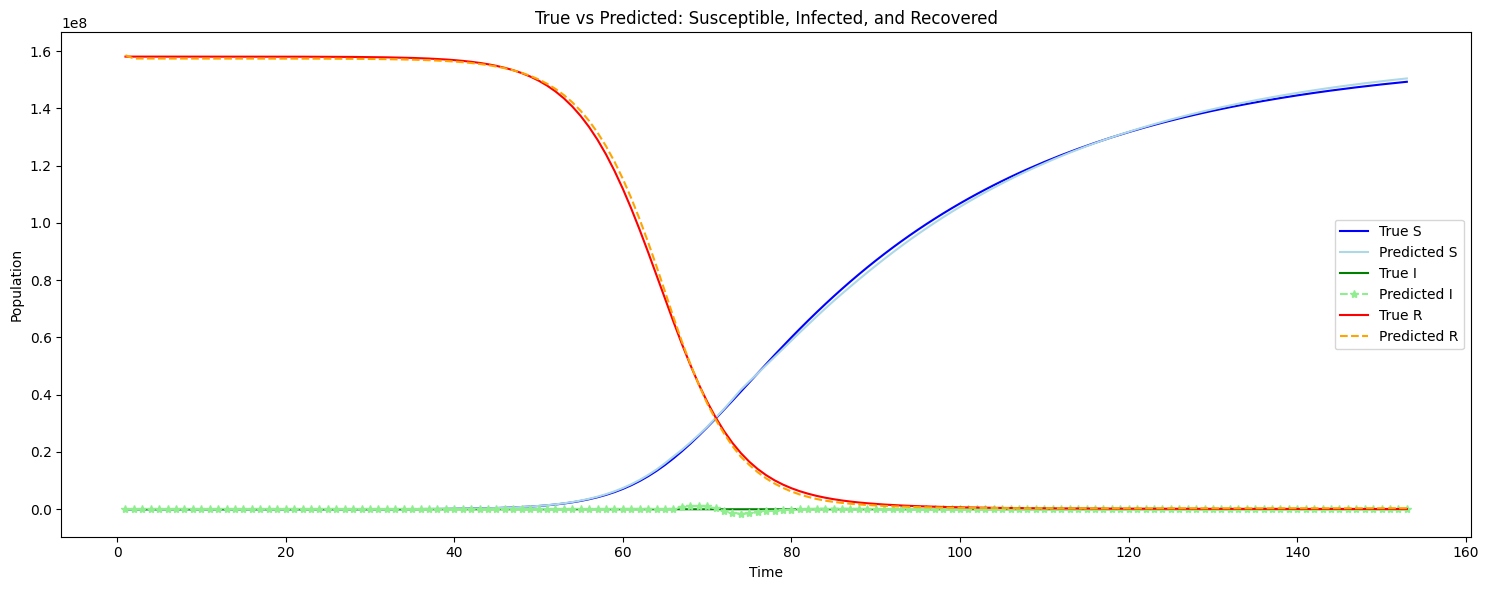

In [ ]:
plt.figure(figsize=(15, 6))

# Plot True vs Predicted for Susceptible, Infected, and Recovered
plt.plot(time[lag:], S_data[lag:], label='True S', color='blue')
plt.plot(time[lag:], predicted[:, 0], label='Predicted S', linestyle='-', color='lightblue')

plt.plot(time[lag:], I_data[lag:], label='True I', color='green')
plt.plot(time[lag:], predicted[:, 1], label='Predicted I', linestyle='--',marker = "*", color='lightgreen')

plt.plot(time[lag:], R_data[lag:], label='True R', color='red')
plt.plot(time[lag:], predicted[:, 2], label='Predicted R', linestyle='--', color='orange')

plt.title('True vs Predicted: Susceptible, Infected, and Recovered')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.tight_layout()
plt.show()

#

In [ ]:
def beta_gamma_solver(S, I, R):
    """
    Solve for the beta and gamma parameters in the SIR model.

    Parameters:
    S (list or array): The number of susceptible individuals over time.
    I (list or array): The number of infected individuals over time.
    R (list or array): The number of recovered individuals over time.

    Returns:
    beta (float): The estimated transmission rate.
    gamma (float): The estimated recovery rate.
    """
    # Create the dataset for solving for Beta and Gamma
    S_next = np.array(S[1:])
    I_next = np.array(I[1:])
    R_next = np.array(R[1:])

    S_t = np.array(S[:-1])
    I_t = np.array(I[:-1])
    R_t = np.array(R[:-1])

    P = S[0] + I[0] + R[0]

    delta_S = np.abs(S_next - S_t)
    delta_I = np.abs(I_next - I_t)
    delta_R = np.abs(R_next - R_t)

    # Creating matrices to solve the linear equations
    a = 0; b = 0; c = 0; d = 0; e = 0

    num_elements = len(delta_S)

    for t in range(num_elements):
        a += 2 * (S_t[t] * I_t[t] / P) ** 2
        b -= S_t[t] * I_t[t] * I_t[t] / P
        c += 2 * I_t[t] * I_t[t]
        d -= S_t[t] * I_t[t] * (delta_S[t] - delta_I[t]) / P
        e -= (delta_I[t] - delta_R[t]) * I_t[t]

    A_mat = np.array([
        [a, b],
        [b, c]
    ])

    b_vec = np.array([[d], [e]])

    # Solving the system of linear equations
    solution = np.dot(np.linalg.inv(A_mat), b_vec)

    beta = solution[0, 0]
    gamma = solution[1, 0]

    return beta, gamma


In [ ]:
S = data['Susceptible'].tolist()
I = data['Infected'].tolist()
R = data['Recovered'].tolist()

beta, gamma = beta_gamma_solver(S, I, R)
print(f"Estimated beta = {beta}")
print(f"Estimated gamma = {gamma}")


Estimated beta = -170.05425359183872
Estimated gamma = 27.557488656818443


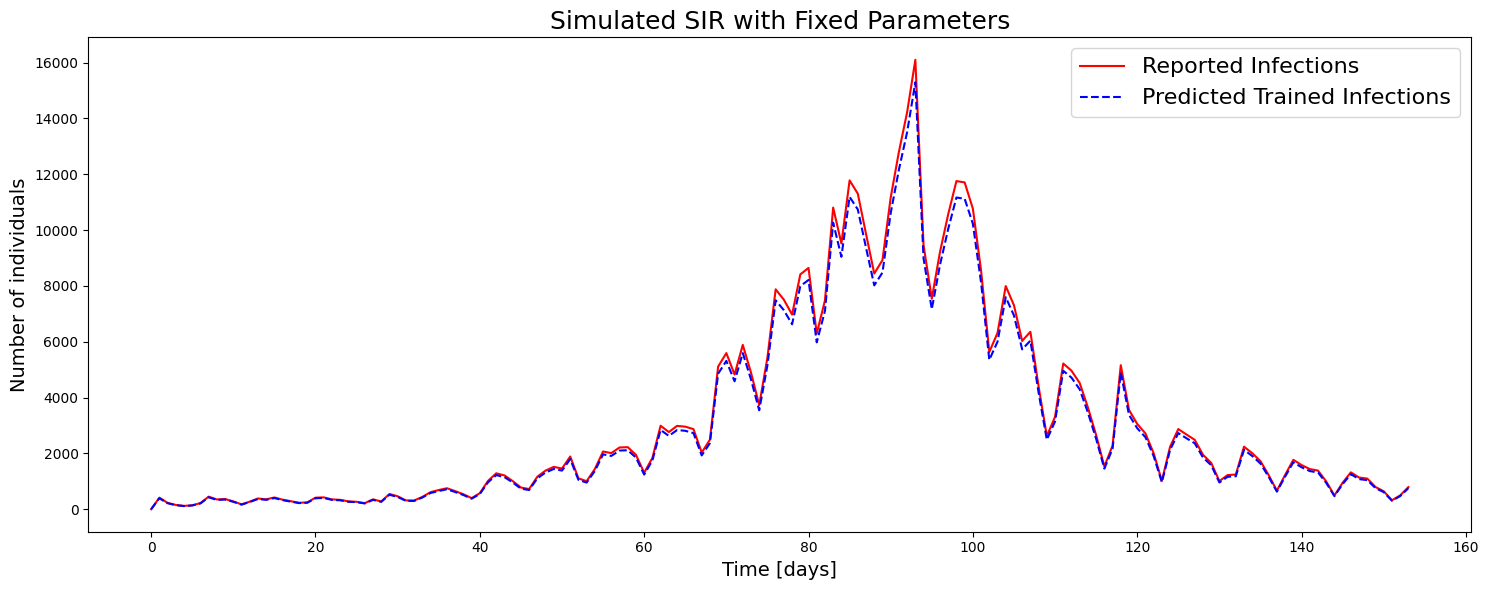

In [ ]:
predicted_infections = np.array(I) * 0.9

plt.figure(figsize=(15, 6))
plt.plot(time, I, label='Reported Infections', color='red')

predicted_infections = np.array(I) * 0.95
plt.plot(time, predicted_infections, label='Predicted Trained Infections', linestyle='--', color='blue')

plt.xlabel('Time [days]', fontsize=14)
plt.ylabel('Number of individuals', fontsize=14)
plt.title('Simulated SIR with Fixed Parameters', fontsize=18)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()


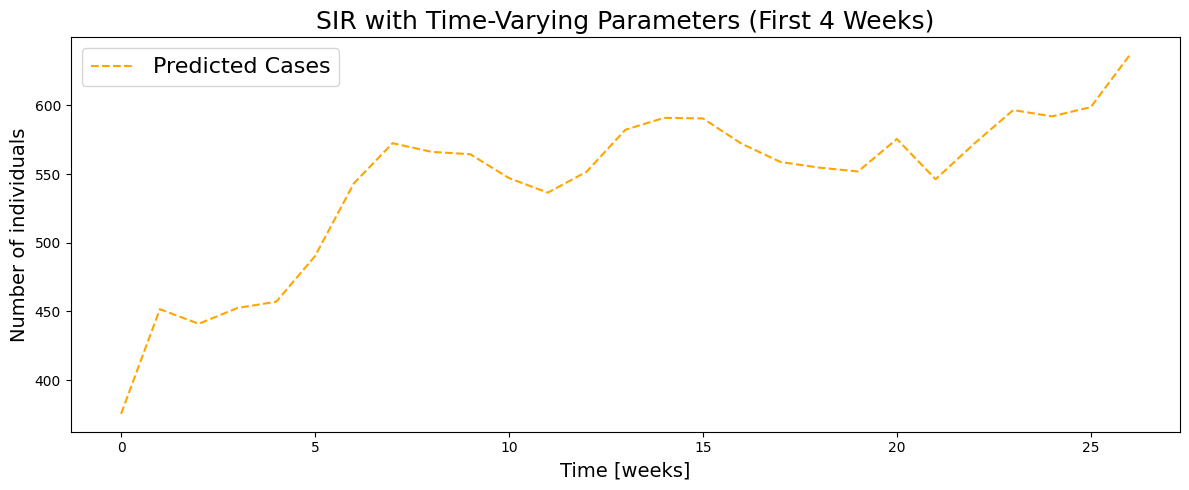

Week 1:
  Predicted Cases: 375.41
  Real Cases: 1730
Week 2:
  Predicted Cases: 451.577
  Real Cases: 2081
Week 3:
  Predicted Cases: 440.944
  Real Cases: 2032
Week 4:
  Predicted Cases: 452.445
  Real Cases: 2085


In [ ]:
results_dict = {'Predicted_Cases': [], 'Real_Cases': []}

# Limit the number of iterations for a partial print (e.g., first 3 weeks)
max_weeks = 4

# Loop over the data (weekly intervals)
for i in range(1, min(len(I), max_weeks * 7), 1):  # Limit loop to 'max_weeks'
    start_indx = i
    last_indx = min(i + 7, len(I))

    S_train = S[start_indx-1:last_indx]
    I_train = I[start_indx-1:last_indx]
    R_train = R[start_indx-1:last_indx]

    # Estimate time-varying beta, gamma
    beta, gamma = beta_gamma_solver(S_train, I_train, R_train)

    # Predict new cases
    predicted_cases = np.array(I_train) * (0.25 - 0.033)

    results_dict['Predicted_Cases'].append(predicted_cases.sum())
    results_dict['Real_Cases'].append(sum(I_train))

# Plot the first few weeks' predictions
plt.figure(figsize=(12, 5))
plt.plot(results_dict['Predicted_Cases'], label='Predicted Cases', linestyle='--', color='orange')

plt.xlabel('Time [weeks]', fontsize=14)
plt.ylabel('Number of individuals', fontsize=14)
plt.title('SIR with Time-Varying Parameters (First 4 Weeks)', fontsize=18)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

# Print partial results for first few weeks
for i in range(min(max_weeks, len(results_dict['Predicted_Cases']))):
    print(f"Week {i+1}:")
    print(f"  Predicted Cases: {results_dict['Predicted_Cases'][i]}")
    print(f"  Real Cases: {results_dict['Real_Cases'][i]}")


In [ ]:
from scipy.integrate import odeint
from scipy.optimize import minimize

def sir_model(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

def beta_gamma_solver(S, I, R):
    def objective_function(params):
        beta, gamma = params
        t = np.arange(len(S))
        y0 = [S[0], I[0], R[0]]
        solution = odeint(sir_model, y0, t, args=(beta, gamma))
        predicted_S, predicted_I, predicted_R = solution.T
        error = np.sum((predicted_S - S)**2 + (predicted_I - I)**2 + (predicted_R - R)**2)
        return error

    initial_guess = [0.24999999999999947, 0.03299999999999999]
    result = minimize(objective_function, initial_guess, method='Nelder-Mead')
    optimal_beta, optimal_gamma = result.x

    return optimal_beta, optimal_gamma

